In [1]:
# 라이브러리 호출
%matplotlib inline
import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import numpy as np
from pathlib import Path
import cv2

# 유틸리티 함수 정의
def create_count_df(df, field, index):
    count = df.groupby(field)[index].count().sort_values(ascending=False)
    count_df = count.to_frame().reset_index()
    count_df.columns = [field, field + '_count']
    return count_df

def plot_count_df(df, field, random_sample, color, rotation, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10,6))
    if random_sample:
        df = df.sample(n=50, random_state=1)
    bars = ax.bar(df[field], df[field + '_count'], color=color, align='center', alpha=0.5)
    for i, b in enumerate(bars):
        ax.text(b.get_x()+b.get_width()*(1/2), b.get_height()+0.1,
                df.iloc[i][field + '_count'], ha='center', fontsize=13)
    ax.set_xticklabels(df[field], rotation=rotation, fontsize=13)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()

In [16]:
# json 파일 읽기
def read_json(filename):
    with Path(filename).open(encoding='utf8') as handle:
        ann = json.load(handle)
    return ann

path_lists = glob.glob(f"./data/cord_receipt/ufo/*train.json")

# 각 json 파일을 읽어서 하나로 합친다
data = {}
data['images'] = {}
for path in path_lists:
    json_data = read_json(path)
    images = list(json_data['images'].items())[:100]  # 각 파일에서 100개씩만
    data['images'].update(dict(images))

print(f"Total number of images: {len(data['images'])}")

Total number of images: 100


In [23]:
# 데이터 구조화
df = {
    'image': [],              
    'word_counts': [],        
    'image_width': [],        
    'image_height': [],       
    'image_tags': [],         
}

# 전체 단어 정보를 저장할 리스트들
words_info = {
    'index': [],
    'text': [],
    'language': [],
    'orientation': [],
    'word_tags': [],
    'bbox_width': [],
    'bbox_height': [],
    'bbox_area': [],
    'bbox_size': [],        # bbox_size 추가
    'aspect_ratio': []
}

# 데이터 추출
word_idx = 0  # 단어 인덱스 추적용
for img_id, img_info in data['images'].items():
    # 이미지 정보 저장
    df['image'].append(img_id)
    df['image_width'].append(img_info['img_w'])
    df['image_height'].append(img_info['img_h'])
    df['image_tags'].append(img_info.get('tags', ['None']))
    
    valid_words = 0
    for word_id, word in img_info['words'].items():
        if not word.get('illegibility', False):
            valid_words += 1
            
            # 단어 정보 저장
            words_info['index'].append(word_idx)
            words_info['text'].append(word.get('transcription', ''))
            words_info['language'].append(word.get('language', 'None'))
            words_info['orientation'].append(word.get('orientation', 'Horizontal'))
            words_info['word_tags'].append(word.get('tags', ['None']))
            
            # bbox 계산
            points = np.array(word.get('points', []))
            if len(points) > 0:
                x_coords = points[:, 0]
                y_coords = points[:, 1]
                width = max(x_coords) - min(x_coords)
                height = max(y_coords) - min(y_coords)
                bbox_size = width * height  # bbox_size 계산
                words_info['bbox_width'].append(width)
                words_info['bbox_height'].append(height)
                words_info['bbox_area'].append(width * height)
                words_info['bbox_size'].append(bbox_size)  # bbox_size 추가
                words_info['aspect_ratio'].append(width / height if height != 0 else 0)
            else:
                words_info['bbox_width'].append(0)
                words_info['bbox_height'].append(0)
                words_info['bbox_area'].append(0)
                words_info['bbox_size'].append(0)  # bbox_size 추가
                words_info['aspect_ratio'].append(0)
            
            word_idx += 1
    
    df['word_counts'].append(valid_words)

# DataFrame 생성
image_df = pd.DataFrame(df)
word_df = pd.DataFrame(words_info)

# None 값 처리
image_df['image_tags'] = image_df['image_tags'].apply(lambda x: ['None'] if x is None else x)

Image ID: receipt_00073.jpg
Image Path: data/cord_receipt/img/train/receipt_00073.jpg
Image Size: None x None
Image Tags: []
Total Words: 6


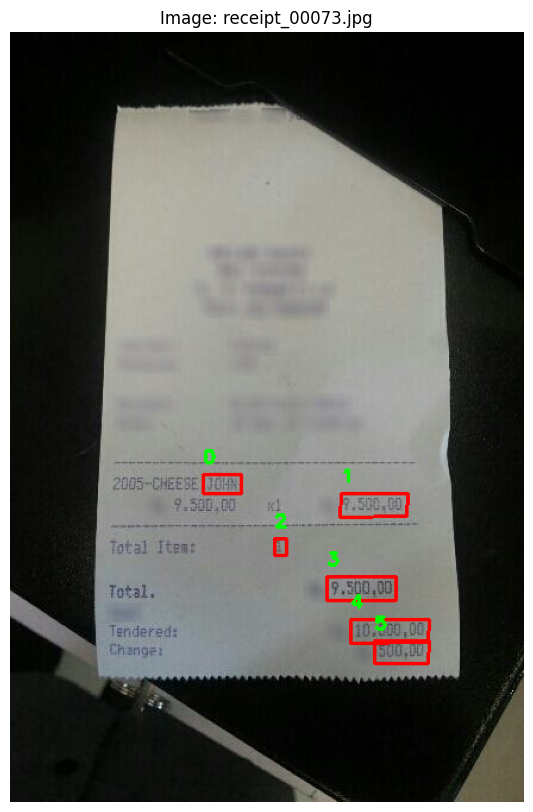


Word Information:
--------------------------------------------------
Word 0:
  Text: JOHN
  Language: None
  Orientation: Horizontal
  Tags: ['None']
--------------------------------------------------
Word 1:
  Text: 9.500,00
  Language: None
  Orientation: Horizontal
  Tags: ['None']
--------------------------------------------------
Word 2:
  Text: 1
  Language: None
  Orientation: Horizontal
  Tags: ['None']
--------------------------------------------------
Word 3:
  Text: 9.500,00
  Language: None
  Orientation: Horizontal
  Tags: ['None']
--------------------------------------------------
Word 4:
  Text: 10.000,00
  Language: None
  Orientation: Horizontal
  Tags: ['None']
--------------------------------------------------
Word 5:
  Text: 500,00
  Language: None
  Orientation: Horizontal
  Tags: ['None']
--------------------------------------------------


In [31]:
# 이미지와 json 경로 설정
def get_image_paths():
    # json 파일 경로
    json_paths = glob.glob(f"./data/cord_receipt/ufo/*train.json")
    
    # 이미지 경로 매핑 딕셔너리 생성
    image_paths = {}
    for json_path in json_paths:
        # json 경로에서 이미지 폴더 경로 추출
        img_dir = str(Path(json_path).parent.parent / 'img/train')
        
        # 해당 폴더의 json 읽기
        json_data = read_json(json_path)
        
        # 각 이미지 ID에 대한 전체 경로 매핑
        for img_id in json_data['images'].keys():
            image_paths[img_id] = str(Path(img_dir) / img_id)
    
    return image_paths

# 이미지 경로 매핑 생성
image_paths = get_image_paths()

# 시각화 함수 수정
def visualize_random_image_with_info(data, image_paths):
    """
    랜덤한 이미지 하나를 선택하여 바운딩 박스와 텍스트 정보를 시각화
    """
    # 랜덤한 이미지 선택
    random_img_id = np.random.choice(list(data['images'].keys()))
    img_info = data['images'][random_img_id]
    
    # 이미지 로드
    img_path = image_paths[random_img_id]
    img = cv2.imread(img_path)
    if img is None:
        print(f"Cannot load image: {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 이미지 정보 출력
    print("="*50)
    print(f"Image ID: {random_img_id}")
    print(f"Image Path: {img_path}")
    print(f"Image Size: {img_info['img_w']} x {img_info['img_h']}")
    print(f"Image Tags: {img_info.get('tags', ['None'])}")
    print(f"Total Words: {len(img_info['words'])}")
    print("="*50)
    
    # 단어 정보를 저장할 리스트
    word_info_list = []
    
    # 이미지에 바운딩 박스 그리기
    for word_id, word in img_info['words'].items():
        if not word.get('illegibility', False):
            points = np.array(word.get('points', []))
            if len(points) > 0:
                # 박스 그리기
                cv2.polylines(img, [points.astype(np.int32)], True, (255, 0, 0), 2)
                
                # 텍스트 번호 표시 (박스 왼쪽 상단)
                x, y = points[0]
                cv2.putText(img, str(len(word_info_list)), (int(x), int(y)-10), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                
                # 단어 정보 저장
                word_info = {
                    'index': len(word_info_list),
                    'text': word.get('transcription', ''),
                    'language': word.get('language', 'None'),
                    'orientation': word.get('orientation', 'Horizontal'),
                    'tags': word.get('tags', ['None'])
                }
                word_info_list.append(word_info)
    
    # 이미지 표시
    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.title(f'Image: {random_img_id}')
    plt.axis('off')
    plt.show()
    
    # 단어 정보 출력
    print("\nWord Information:")
    print("-"*50)
    for word_info in word_info_list:
        print(f"Word {word_info['index']}:")
        print(f"  Text: {word_info['text']}")
        print(f"  Language: {word_info['language']}")
        print(f"  Orientation: {word_info['orientation']}")
        print(f"  Tags: {word_info['tags']}")
        print("-"*50)

# 실행
visualize_random_image_with_info(data, image_paths)